In [75]:
import new_model as model_mobster_mv
import numpy as np
import pandas as pd
import pyro.distributions as dist
import scipy.stats as stats
import torch
import pyro

import matplotlib.pyplot as plt

from utils.plot_functions import *
from utils.BoundedPareto import BoundedPareto
from utils.create_beta_pareto_dataset import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def beta_lk(mb,idx,  d, a_beta, b_beta):
    """
    Compute beta-binomial likelihood for a single dimension of a single cluster.
    """
    betabin = dist.BetaBinomial(a_beta, b_beta, total_count=mb.DP[idx,d]).log_prob(mb.NV[idx,d])
    return betabin # simply does log(weights) + log(density)

def expon_lk(mb, idx,  d):
    """
    Compute exponential likelihood for a single dimension of a single cluster.
    """
    exp = dist.Exponential(mb.rate_expon).log_prob(mb.NV[idx,d])
    return exp # simply does log(weights) + log(density)

def pareto_binomial_pmf(mb, NV, DP, alpha):
    integration_points=2000
    # Generate integration points across all rows at once
    t = torch.linspace(mb.pareto_L, mb.pareto_H, integration_points).unsqueeze(0)  # Shape (1, integration_points)
    NV_expanded = NV.unsqueeze(-1)  # Shape (NV.shape[0], NV.shape[1], 1)
    DP_expanded = DP.unsqueeze(-1)  # Shape (NV.shape[0], DP.shape[1], 1)
    binom_vals = dist.Binomial(total_count=DP_expanded, probs=t).log_prob(NV_expanded).exp()
    pareto_vals = BoundedPareto(mb.pareto_L, alpha, mb.pareto_H).log_prob(t).exp()  # Shape (1, integration_points)
    integrand = binom_vals * pareto_vals

    pmf_x = torch.trapz(integrand, t, dim=-1).log()  # Shape (NV.shape[0], NV.shape[1])

    return pmf_x.tolist()  # Convert the result to a list

def pareto_lk(mb, idx, d, alpha):
    paretobin = torch.tensor(pareto_binomial_pmf(mb, NV=mb.NV[idx, d], DP=mb.DP[idx, d], alpha=alpha))
    return paretobin # tensor of len N (if D = 1, only N)

### Synthetic samples

In [102]:
def euclidean_distance(a, b):
    return torch.dist(a, b)

# Define the Pareto-Binomial function
def pareto_binomial(N, alpha, L, H, depth):
    p = BoundedPareto(scale=L, alpha=alpha, upper_limit=H).sample((N,))
    bin = dist.Binomial(total_count=depth, probs=p).sample()
    min_bin = torch.ceil(L * depth)
    bin = torch.max(bin, min_bin)
    return bin

# Define the Beta-Binomial function
def beta_binomial(N, phi, kappa, depth):
    a = phi * kappa
    b = (1 - phi) * kappa
    p = dist.Beta(a, b).sample((N,))
    return dist.Binomial(total_count=depth, probs=p).sample()

def sample_mixing_prop(K, min_value=0.05):
    while True: # loop until valid sample
        sample = dist.Dirichlet(torch.ones(K)).sample()
        if (sample > min_value).all():
            return sample


In [103]:

def generate_data_new_model(N, K, pi, D, purity, coverage):
    NV = torch.zeros((N, D))
    threshold=0.12
    cluster_labels = torch.zeros(N)  # one-dimensional labels, one per data
    type_labels_data = torch.zeros((N, D))  # D-dimensional labels, one per data
    type_labels_cluster = torch.zeros((K, D))  # D-dimensional label, one per cluster
    phi_param_data = torch.zeros((N, D))
    kappa_param_data = torch.zeros((N, D))
    alpha_param_data = torch.zeros((N, D))
    phi_param_cluster = torch.zeros((K, D))
    kappa_param_cluster = torch.zeros((K, D))
    alpha_param_cluster = torch.zeros((K, D))
    max_vaf = purity/2
    probs_pareto = 0.08

    # variance_negbin = 1000
    # mean_negbin = coverage
    # probs_negbin = mean_negbin/variance_negbin
    # n_negbin = mean_negbin**2/(variance_negbin-mean_negbin)
    # neg_bin = stats.nbinom.rvs(n_negbin, probs_negbin, size=N*D)
    # depth = torch.tensor(neg_bin).reshape([N,D])
    depth = dist.Poisson(coverage).sample([N,D])

    sampled_phi_list = []

    # Always have a Beta-Binomial component with phi=max_vaf in all dimensions
    k = 0
    for d in range(D):
        p = max_vaf
        kappa = dist.Uniform(90, 350).sample()
        NV[:pi[k], d] = beta_binomial(pi[k], p, kappa, depth[:pi[k],d])
        type_labels_data[:pi[k], d] = torch.tensor(1)  # beta
        type_labels_cluster[k, d] = torch.tensor(1)  # beta
        phi_param_data[:pi[k], d] = p
        kappa_param_data[:pi[k], d] = round(kappa.item(), 3)
        alpha_param_data[:pi[k], d] = -1
        phi_param_cluster[k, d] = p
        kappa_param_cluster[k, d] = round(kappa.item(), 3)
        alpha_param_cluster[k, d] = -1
    cluster_labels[:pi[k]] = k  # cluster k
    sampled_phi_list.append(torch.tensor([p] * D))

    # Always have a Pareto-Binomial component in all dimensions
    k = 1
    pareto_L = torch.tensor(0.05)  # Scale Pareto
    pareto_H = torch.tensor(max_vaf)  # Upper bound Pareto
    init_idx = np.sum(pi[:k])
    end_idx = init_idx + pi[k]
    for d in range(D):
        alpha = dist.Uniform(0.8, 1.5).sample()  # Pareto shape parameter
        NV[init_idx:end_idx, d] = pareto_binomial(pi[k], alpha, pareto_L, pareto_H, depth[init_idx:end_idx, d])
        type_labels_data[init_idx:end_idx, d] = torch.tensor(0)  # pareto
        type_labels_cluster[k, d] = torch.tensor(0)  # pareto
        phi_param_data[init_idx:end_idx, d] = -1
        kappa_param_data[init_idx:end_idx, d] = -1
        alpha_param_data[init_idx:end_idx, d] = round(alpha.item(), 3)
        phi_param_cluster[k, d] = -1
        kappa_param_cluster[k, d] = -1
        alpha_param_cluster[k, d] = round(alpha.item(), 3)
    cluster_labels[init_idx:end_idx] = k  # cluster k
    sampled_phi_list.append(torch.tensor([probs_pareto] * D))

    # Randomly sample from Beta-Binomial, Pareto-Binomial or Zeros for additional components
    for k in range(2, K):
        init_idx = np.sum(pi[:k])
        end_idx = init_idx + pi[k]
        pareto_count = 0
        zeros_count = 0
        cluster_labels[init_idx:end_idx] = k  # cluster k
        while True:
            curr_sampled_phi = []
            for d in range(D):
                choose_dist = torch.randint(1, 4, (1,)).item() # randomly sample a value between 1, 2 or 3
                if choose_dist == 1:
                    phi, kappa = dist.Uniform(0.15, 0.5).sample(), dist.Uniform(90, 350).sample()
                    NV[init_idx:end_idx, d] = beta_binomial(pi[k], phi, kappa, depth[init_idx:end_idx, d])
                    type_labels_data[init_idx:end_idx, d] = torch.tensor(1)  # beta
                    type_labels_cluster[k, d] = torch.tensor(1)  # beta
                    phi_param_data[init_idx:end_idx, d] = round(phi.item(), 3)
                    kappa_param_data[init_idx:end_idx, d] = round(kappa.item(), 3)
                    alpha_param_data[init_idx:end_idx, d] = -1
                    phi_param_cluster[k, d] = round(phi.item(), 3)
                    kappa_param_cluster[k, d] = round(kappa.item(), 3)
                    alpha_param_cluster[k, d] = -1
                    curr_sampled_phi.append(phi)
                elif choose_dist == 2: # Pareto-Binomial for this dimension
                    if pareto_count >= (D-1): 
                        # if the number of pareto dimensions are already D-1 (all but 1), then sample either a beta or zeros
                        if torch.rand(1).item() < 0.5 and zeros_count < (D-1): # zeros
                            phi = 0
                            type_labels_cluster[k, d] = torch.tensor(2)  # zeros
                            NV[init_idx:end_idx, d] = phi
                            phi_param_data[init_idx:end_idx, d] = -1
                            kappa_param_data[init_idx:end_idx, d] = -1
                            alpha_param_data[init_idx:end_idx, d] = -1
                            phi_param_cluster[k, d] = -1
                            kappa_param_cluster[k, d] = -1
                            alpha_param_cluster[k, d] = -1
                            zeros_count += 1
                            curr_sampled_phi.append(phi)                            
                        else: # beta
                            phi, kappa = dist.Uniform(0.15, 0.5).sample(), dist.Uniform(90, 350).sample()
                            NV[init_idx:end_idx, d] = beta_binomial(pi[k], phi, kappa, depth[init_idx:end_idx, d])
                            type_labels_data[init_idx:end_idx, d] = torch.tensor(1)  # beta
                            type_labels_cluster[k, d] = torch.tensor(1)  # beta
                            phi_param_data[init_idx:end_idx, d] = round(phi.item(), 3)
                            kappa_param_data[init_idx:end_idx, d] = round(kappa.item(), 3)
                            alpha_param_data[init_idx:end_idx, d] = -1
                            phi_param_cluster[k, d] = round(phi.item(), 3)
                            kappa_param_cluster[k, d] = round(kappa.item(), 3)
                            alpha_param_cluster[k, d] = -1                            
                            curr_sampled_phi.append(phi)
                            
                    else: # pareto
                        alpha = dist.Uniform(0.8, 1.5).sample()
                        NV[init_idx:end_idx, d] = pareto_binomial(pi[k], alpha, pareto_L, pareto_H, depth[init_idx:end_idx, d])
                        type_labels_data[init_idx:end_idx, d] = torch.tensor(0)  # pareto
                        type_labels_cluster[k, d] = torch.tensor(0)  # pareto
                        phi_param_data[init_idx:end_idx, d] = -1
                        kappa_param_data[init_idx:end_idx, d] = -1
                        alpha_param_data[init_idx:end_idx, d] = round(alpha.item(), 3)
                        phi_param_cluster[k, d] = -1
                        kappa_param_cluster[k, d] = -1
                        alpha_param_cluster[k, d] = round(alpha.item(), 3)
                        pareto_count += 1
                        curr_sampled_phi.append(probs_pareto)
                elif choose_dist == 3: # Zeros for this dimension
                    if zeros_count >= (D-1): 
                        # if the number of zeros dimensions are already D-1 (all but 1), then sample either a beta or a pareto
                        if torch.rand(1).item() < 0.5 and pareto_count < (D-1):  # zeros
                            alpha = dist.Uniform(0.8, 1.5).sample()
                            NV[init_idx:end_idx, d] = pareto_binomial(pi[k], alpha, pareto_L, pareto_H, depth[init_idx:end_idx, d])
                            type_labels_data[init_idx:end_idx, d] = torch.tensor(0)  # pareto
                            type_labels_cluster[k, d] = torch.tensor(0)  # pareto
                            phi_param_data[init_idx:end_idx, d] = -1
                            kappa_param_data[init_idx:end_idx, d] = -1
                            alpha_param_data[init_idx:end_idx, d] = round(alpha.item(), 3)
                            phi_param_cluster[k, d] = -1
                            kappa_param_cluster[k, d] = -1
                            alpha_param_cluster[k, d] = round(alpha.item(), 3)
                            pareto_count += 1
                            curr_sampled_phi.append(probs_pareto)
                        else: # beta
                            phi, kappa = dist.Uniform(0.15, 0.5).sample(), dist.Uniform(90, 350).sample()
                            NV[init_idx:end_idx, d] = beta_binomial(pi[k], phi, kappa, depth[init_idx:end_idx, d])
                            type_labels_data[init_idx:end_idx, d] = torch.tensor(1)  # beta
                            type_labels_cluster[k, d] = torch.tensor(1)  # beta
                            phi_param_data[init_idx:end_idx, d] = round(phi.item(), 3)
                            kappa_param_data[init_idx:end_idx, d] = round(kappa.item(), 3)
                            alpha_param_data[init_idx:end_idx, d] = -1
                            phi_param_cluster[k, d] = round(phi.item(), 3)
                            kappa_param_cluster[k, d] = round(kappa.item(), 3)
                            alpha_param_cluster[k, d] = -1
                            curr_sampled_phi.append(phi)
                    else:
                        phi = 0
                        type_labels_cluster[k, d] = torch.tensor(2)  # zeros
                        NV[init_idx:end_idx, d] = phi
                        phi_param_data[init_idx:end_idx, d] = -1
                        kappa_param_data[init_idx:end_idx, d] = -1
                        alpha_param_data[init_idx:end_idx, d] = -1
                        phi_param_cluster[k, d] = -1
                        kappa_param_cluster[k, d] = -1
                        alpha_param_cluster[k, d] = -1
                        zeros_count += 1
                        curr_sampled_phi.append(phi)

            
            # Convert curr_sampled_phi to a tensor
            curr_sampled_phi_tensor = torch.tensor(curr_sampled_phi)
            
            # Check if curr_sampled_phi list has a euclidean distance < threshold from all the already present element in sampled_phi_list:
            # if yes, add it to sampled_phi_list and go to the next iteration of k, otherwise repeat this loop over d
            
            # Check if the Euclidean distance is below the threshold for any sampled_phi in sampled_phi_list
            if all(euclidean_distance(curr_sampled_phi_tensor, phi) >= threshold for phi in sampled_phi_list):
                # If no element in sampled_phi_list is too close, add to sampled_phi_list and break the loop
                sampled_phi_list.append(curr_sampled_phi_tensor)
                break  # Move to the next cluster
    return NV, depth, cluster_labels, type_labels_data, type_labels_cluster, phi_param_data, kappa_param_data, alpha_param_data, phi_param_cluster, kappa_param_cluster, alpha_param_cluster

In [104]:
def plot_marginals_real(NV, DP, N, K, D, type_labels_cluster, cluster_labels, phi_beta, kappa_beta, alpha, idx):
    vaf = NV/DP
    copy_vaf = torch.clone(vaf)
    # Replace zeros with a large value that will not be considered as minimum (i.e. 1)
    masked_tensor = copy_vaf.masked_fill(vaf == 0, float(1.))

    # Find the minimum value for each column excluding zeros
    min_values, _ = torch.min(masked_tensor, dim=0)
    min_values = min_values.repeat(K, 1)
    pareto_L = torch.min(min_values)
    print(min_values)
    if K == 1:
        fig, axes = plt.subplots(K, NV.shape[1], figsize=(16, 4))
    else:
        fig, axes = plt.subplots(K, NV.shape[1], figsize=(16, K*3))
    if K == 1:
        axes = ax = np.array([axes])  # add an extra dimension to make it 2D
    plt.suptitle(f"Marginals with N = {N} and {K} clusters (i = {idx}) \n ")
    x = np.linspace(0.001, 1, 1000)
    for k in range(K):
        for d in range(D):
            maxx = type_labels_cluster[k, d]
            # print(maxx)
            if maxx == 1:
                # plot beta
                a = phi_beta[k,d] * kappa_beta[k,d]
                b = (1-phi_beta[k,d]) * kappa_beta[k,d]
                pdf = beta.pdf(x, a, b)
                axes[k,d].plot(x, pdf, linewidth=1.5, label='Beta', color='r')
                axes[k,d].legend()
            elif maxx == 0:
                #plot pareto
                # print(alpha[k,d])
                pdf = pareto.pdf(x, alpha[k,d], scale=pareto_L)
                axes[k,d].plot(x, pdf, linewidth=1.5, label='Pareto', color='g')
                axes[k,d].legend()
            else:
                # private
                a_beta_zeros = torch.tensor(1e-3)
                b_beta_zeros = torch.tensor(1e3)
                pdf = beta.pdf(x, a_beta_zeros, b_beta_zeros) # delta_approx
                axes[k,d].plot(x, pdf, linewidth=1.5, label='Zeros', color='b')
                axes[k,d].legend()
            
            if torch.is_tensor(NV):
                data = NV[:,d].numpy()/DP[:,d].numpy()
            else:
                data = np.array(NV[:,d])/np.array(DP[:,d])
            # data = mb.NV[:,d].numpy()/mb.DP[:,d].numpy()
            # for i in np.unique(labels):
            axes[k,d].hist(data[cluster_labels == k], density=True, bins=30, alpha=0.5)#, color=cmap(i))
            axes[k,d].set_title(f"Sample {d+1} - Cluster {k}")
            axes[k,d].set_xlim([-0.01,1])
            plt.tight_layout()
    # plt.savefig(f"plots/real_marginals/N_{N}_K_{K}_D_{D}_real_{idx}.png")
    plt.show()
    plt.close()


tensor([0.0716, 0.0644, 0.0664, 0.0603, 0.1861, 0.2703, 0.1691, 0.1119])
tensor([ 71.6040,  64.3773,  66.3533,  60.2884, 186.1179, 270.2571, 169.1288,
        111.8731])
np.sum(pi) 999


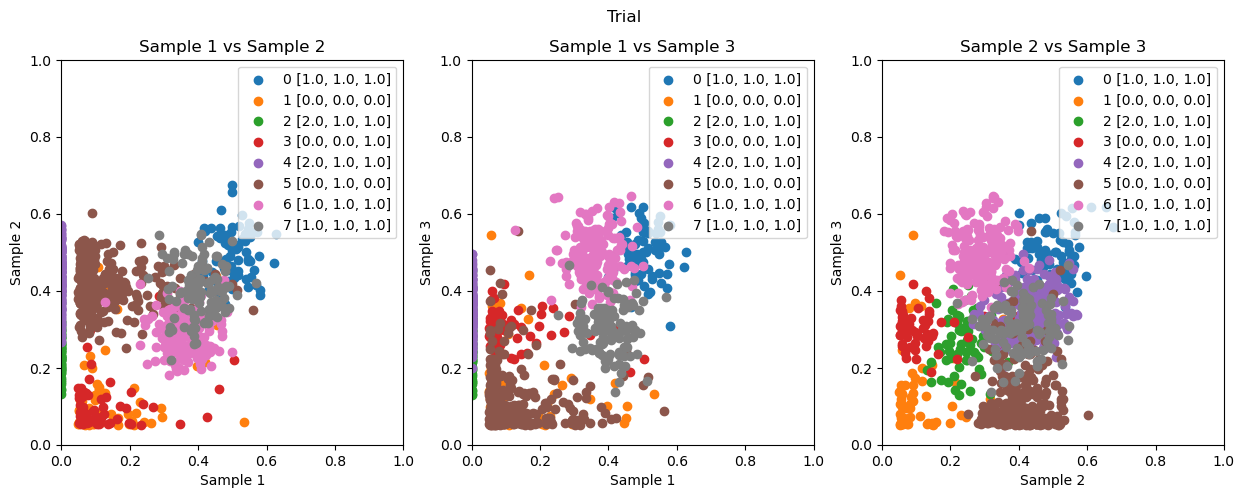

tensor([[0.0500, 0.0500, 0.0500],
        [0.0500, 0.0500, 0.0500],
        [0.0500, 0.0500, 0.0500],
        [0.0500, 0.0500, 0.0500],
        [0.0500, 0.0500, 0.0500],
        [0.0500, 0.0500, 0.0500],
        [0.0500, 0.0500, 0.0500],
        [0.0500, 0.0500, 0.0500]])


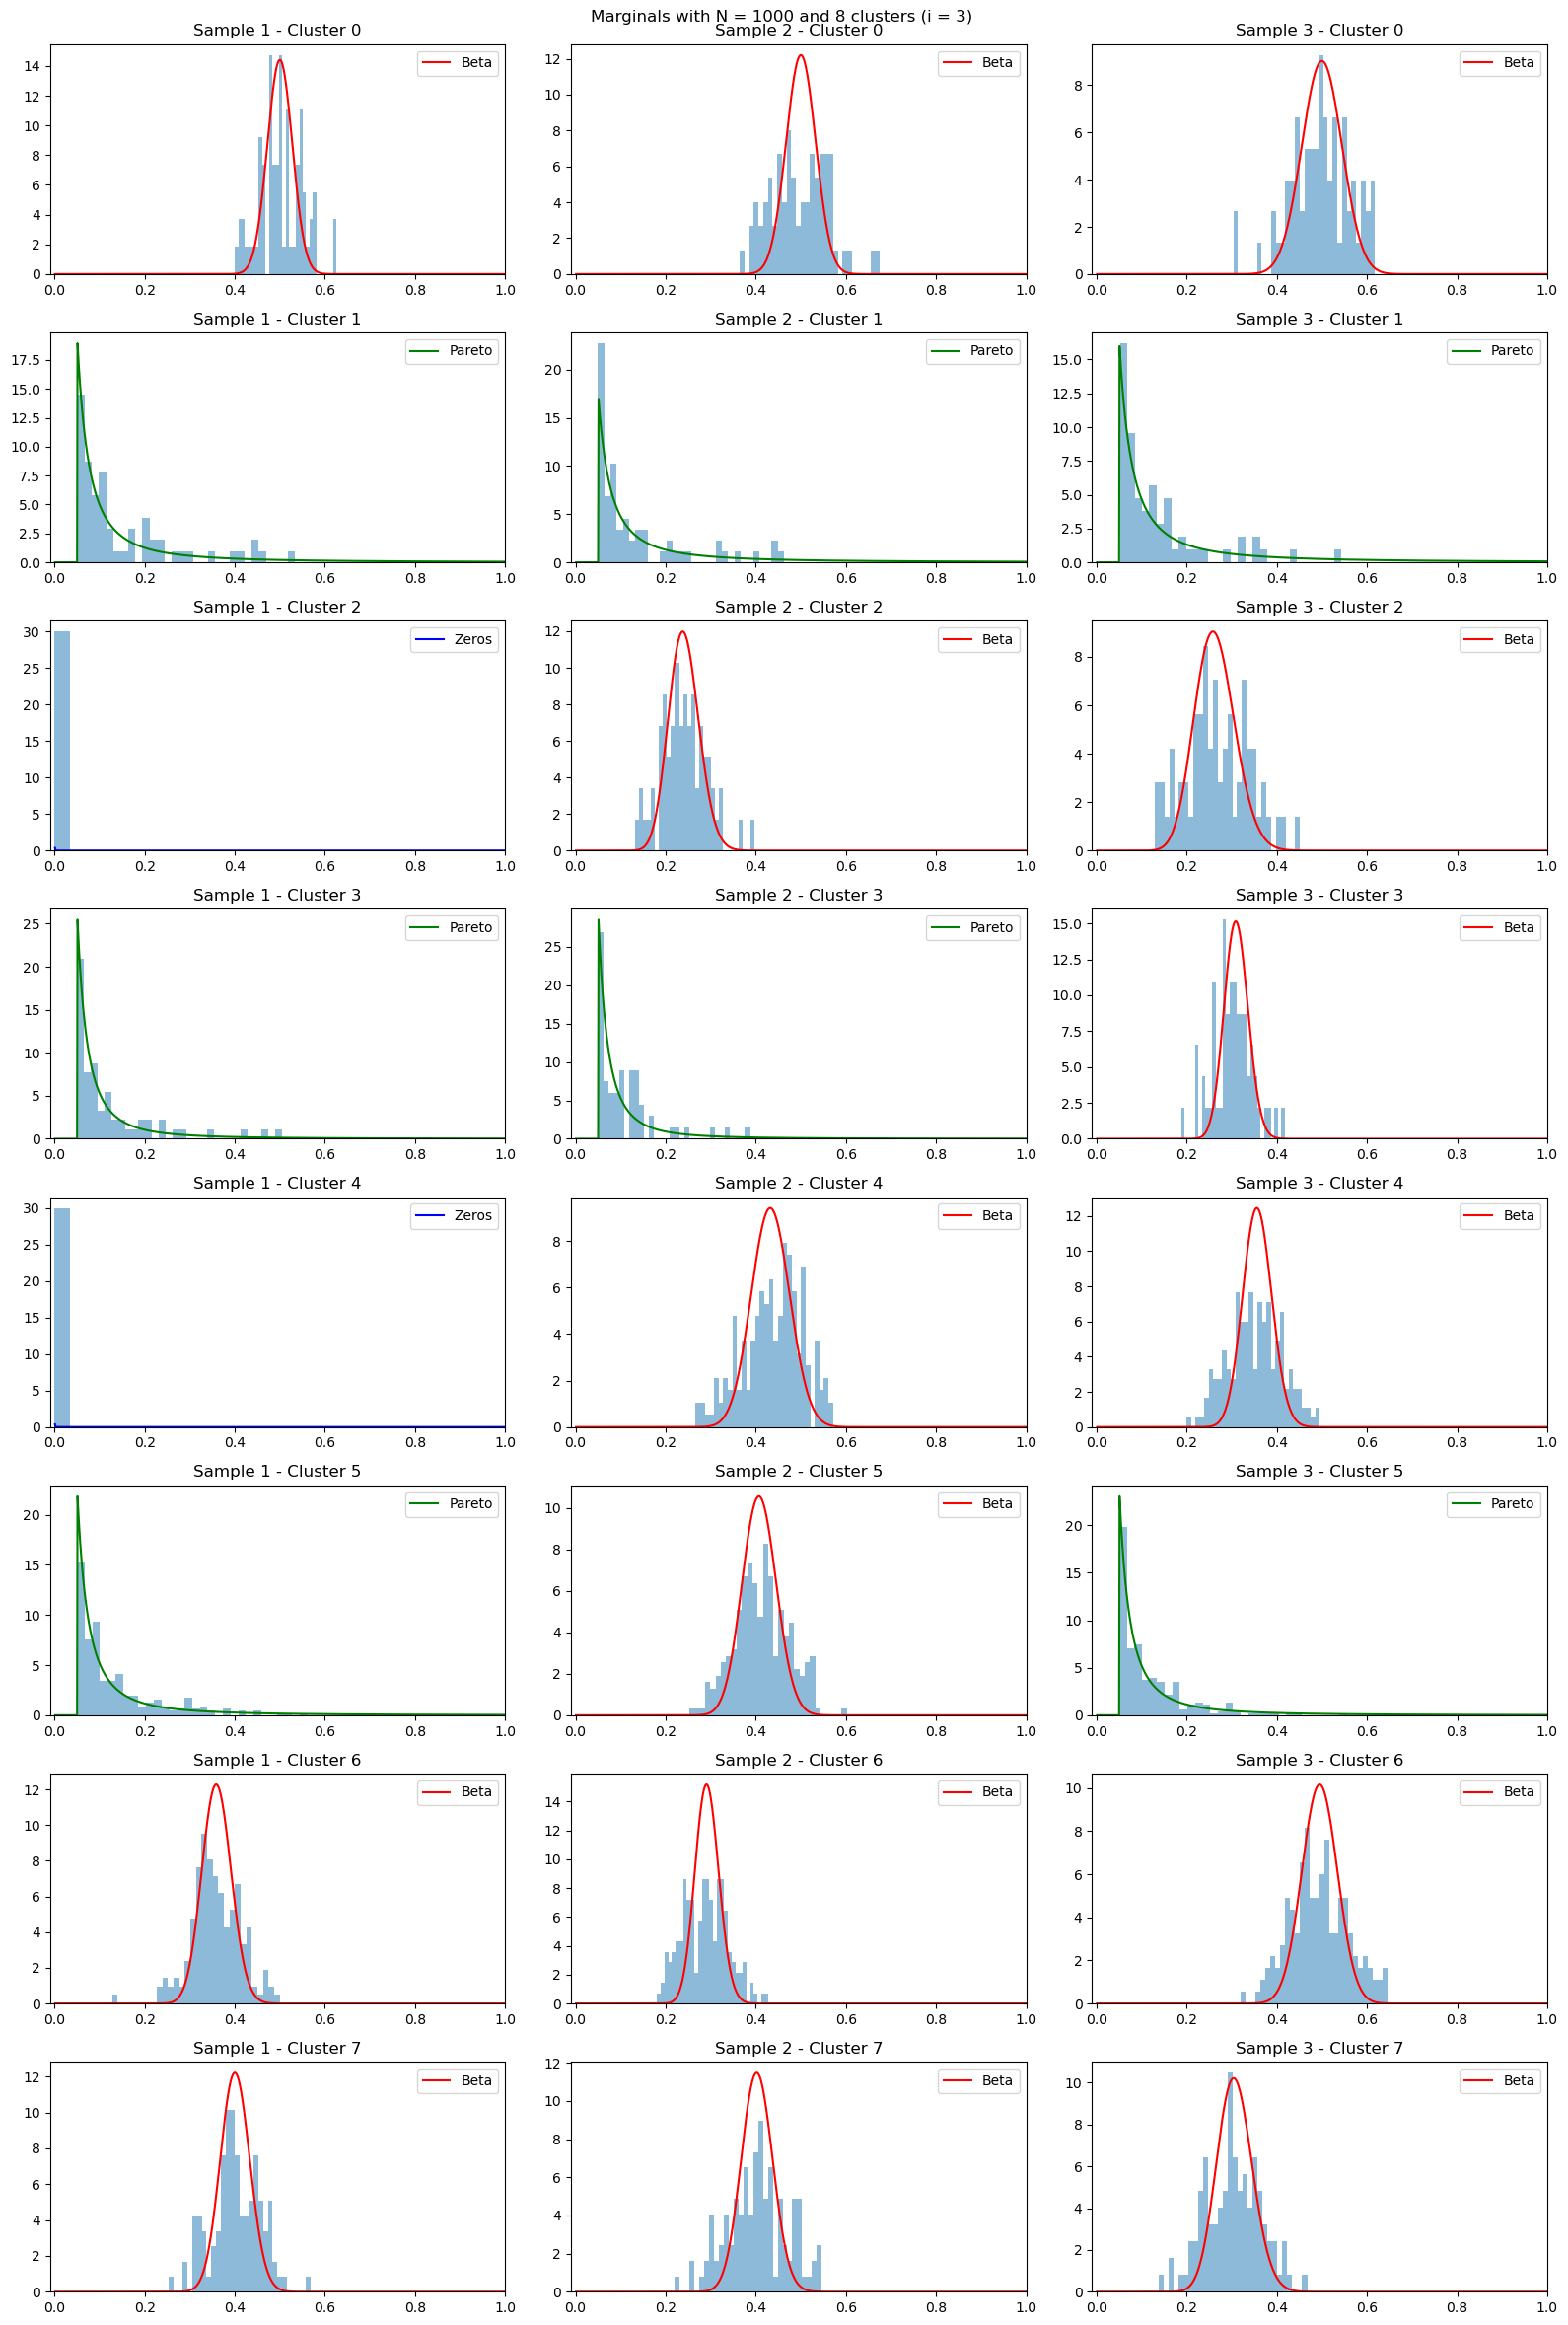

In [105]:
purity = 1
coverage = 100
N = 1000
K = 8
D = 3

# seed1 = 0
# pyro.set_rng_seed(seed1)
# torch.manual_seed(seed1)
# np.random.seed(seed1)

# Sample mixing proportions for clusters and multiply by N to obtain the number of data in each cluster
pi = sample_mixing_prop(K) * N
print(pi/N)
print(pi)
# pi = dist.Dirichlet(torch.ones(K)).sample() * N  # Number of data in each cluster
pi = np.round(pi.numpy()).astype('int')

# Adjust proportions to ensure they sum to N
print("np.sum(pi)", np.sum(pi))
if np.sum(pi) < N:
    diff = N - np.sum(pi)
    pi[-1] += diff
elif np.sum(pi) > N:
    diff = np.sum(pi) - N
    pi[-1] -= diff
NV, DP, cluster_labels, type_labels_data, type_labels_cluster, phi_param_data, kappa_param_data, alpha_param_data, phi_param_cluster, kappa_param_cluster, alpha_param_cluster  = generate_data_new_model(N, K, pi, D, purity, coverage)
        
pairs = np.triu_indices(D, k=1)  # Generate all unique pairs of samples (i, j)
vaf = NV/DP    
num_pairs = len(pairs[0])  # Number of unique pairs
ncols = min(3, num_pairs)
nrows = (num_pairs + ncols - 1) // ncols  # Calculate the number of rows

fig_width_per_plot = 5
fig_width = ncols * fig_width_per_plot
fig_height = 5 * nrows

fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
plt.suptitle('Trial')
if num_pairs == 1:
    axes = [axes]
else:
    axes = axes.flatten()

idx = 0
for i, j in zip(*pairs):
    ax = axes[idx]  # Select the appropriate subplot
    x = vaf[:, i].numpy()
    y = vaf[:, j].numpy()

    # ax.scatter(x, y, alpha=0.7)

    for c, cluster in enumerate(np.unique(cluster_labels)):
        mask = (cluster_labels == cluster)  # Mask for current cluster
        ax.scatter(x[mask], 
                    y[mask],
                    label=f'{cluster.astype("int")} {type_labels_cluster[c].tolist()}')
    ax.legend(loc='best')
    ax.set_title(f"Sample {i+1} vs Sample {j+1}")
    ax.set_xlabel(f"Sample {i+1}")
    ax.set_ylabel(f"Sample {j+1}")
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    idx += 1

plt.show()
plt.close()


plot_marginals_real(NV, DP, N, K, D, type_labels_cluster, cluster_labels, phi_param_cluster, kappa_param_cluster, alpha_param_cluster, idx)

### Negative binomial for DP

In [56]:
sets = [55, 57, 59, 62]
s_number = 7

data = pd.read_csv("./data/real_data/Set7_mutations.csv")

data = pd.read_csv("./data/real_data/Set6_mutations.csv")

sets = [42, 44, 45, 46, 47, 48]
s_number = 6

NV_list = []
DP_list = []

for s in sets:
    NV = torch.tensor(data[f'Set{s_number}_{s}.NV'].to_numpy())
    DP = torch.tensor(data[f'Set{s_number}_{s}.DP'].to_numpy())
    
    NV_list.append(NV.view(-1, 1))  # Ensure correct shape
    DP_list.append(DP.view(-1, 1))  # Ensure correct shape
NV = torch.cat(NV_list, dim=1)
DP = torch.cat(DP_list, dim=1)

In [62]:
data = DP[:,2].numpy()

3577

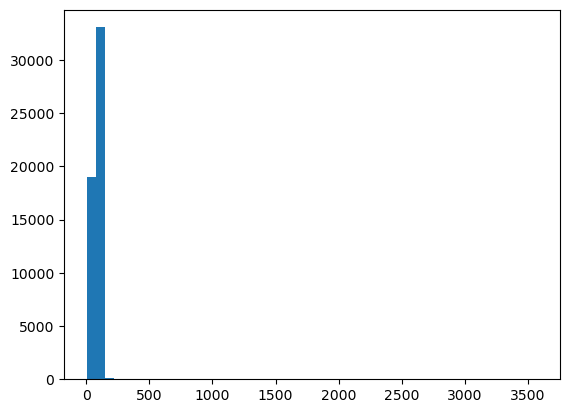

In [49]:
plt.hist(DP[:,0].numpy(), bins = 50);
np.max(DP[:,0].numpy())

In [63]:
mean_coverage = np.mean(data)
median_coverage = np.median(data)

variance = np.var(data)

# Calculate Overdispersion Index
overdispersion_index = variance / mean_coverage
# overdispersion_index = (variance**2 - mean_coverage)/(mean_coverage**2)

print(mean_coverage, median_coverage, variance)

73.56844660194174 74.0 986.5715286549157


tensor([[109,  83, 148],
        [ 93, 160,  95],
        [139,  97,  84],
        ...,
        [115, 110,  78],
        [ 88,  86,  94],
        [ 86, 116,  67]])


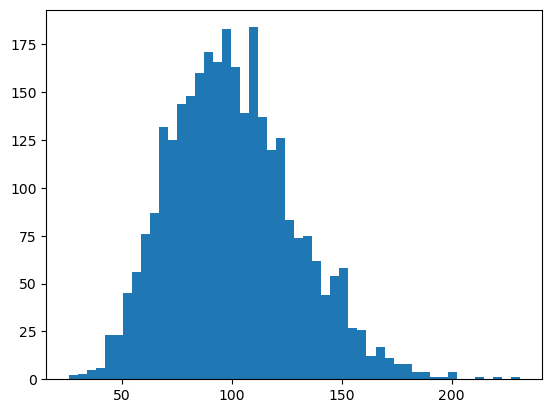

In [ ]:
import scipy.stats as stats
N = 1000
D = 3
variance = 800
mean = 100
probs = mean/variance
n = mean**2/(variance-mean)

neg_bin = stats.nbinom.rvs(n, probs, size=N*D)
# neg_bin = dist.NegativeBinomial(total_count=n, probs=probs).sample([1000])
print(torch.tensor(neg_bin).reshape([N,D]))
plt.hist(neg_bin, bins = 50);

In [69]:
data = pd.read_csv("./data/gbm.csv")

sets = ['primary', 'relapse']

NV_list = []
DP_list = []

for s in sets:
    NV = torch.tensor(data[f'NV_{s}'].to_numpy())
    DP = torch.tensor(data[f'DP_{s}'].to_numpy())
    
    NV_list.append(NV.view(-1, 1))  # Ensure correct shape
    DP_list.append(DP.view(-1, 1))  # Ensure correct shape
NV = torch.cat(NV_list, dim=1)
DP = torch.cat(DP_list, dim=1)

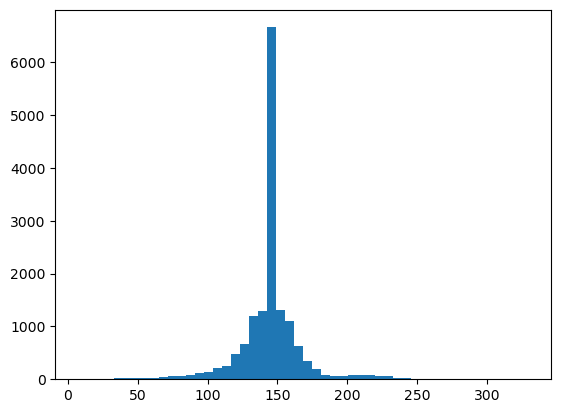

In [74]:
plt.hist(DP[:,0].numpy(), bins = 50);

In [73]:
data = DP[:,0].numpy()
mean_coverage = np.mean(data)
median_coverage = np.median(data)

variance = np.var(data)

print(mean_coverage, median_coverage, variance)

144.46923076923076 145.0 542.4309763313609
